## Import statements

In [384]:

from itertools import product, count

import numpy as np
import matplotlib.pyplot as plt
import skimage
from sklearn.model_selection import train_test_split

%matplotlib inline

## Load the preprocessed data

In [149]:
data = np.load('./preprocessed-data.npz')
X, y, y_labels, alphabet, ids = data['X'], data['y'], data['y_labels'], data['alphabet'], data['ids'].item()

## Create train & test datasets

In [379]:
train_indices, test_indices = train_test_split(np.array(range(0, X.shape[0])), test_size=0.15, shuffle=True, random_state=14)

In [380]:
train_indices.shape

(909,)

In [381]:
test_indices.shape

(161,)

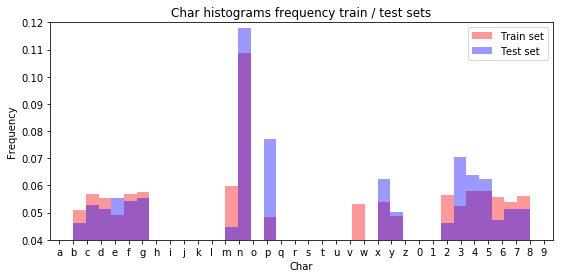

In [382]:
plt.figure(figsize=(9, 4))
plt.hist(y_labels[train_indices,:].flatten(), bins=36, color='red', alpha=0.4, density=True);
plt.hist(y_labels[test_indices,:].flatten(), bins=36, color='blue', alpha=0.4, density=True);

plt.title('Char histograms frequency train / test sets')
plt.xlabel('Char')
plt.ylabel('Frequency')
plt.xticks(range(0, 36))
plt.ylim((0.04, 0.12))
plt.legend(['Train set', 'Test set'])
plt.gca().set_xticklabels(alphabet);

Some characters are not present in any of the captcha texts on the test set and there are characters which appear more frequently on test than train set

## Train / Test split improvement

We can split train and test such that char frequencies in both sets are similar <br/>
The next algorithm performs random swaps between samples of train & test sets to balance char frequencies

In [385]:
max_iters = 200
history = np.repeat(np.inf, max_iters).astype(np.float32)
best_result = None

np.random.seed()

for i in range(0, max_iters):
    train_char_f = y[train_indices, :, :].sum(axis=1).mean(axis=0)
    test_char_f = y[test_indices, :, :].sum(axis=1).mean(axis=0)
    loss = np.sum(np.square(train_char_f - test_char_f))
    
    if np.all(loss < history):
        best_result = {'train':train_indices, 'test':test_indices, 'loss':loss, 'iter':i}
    history[i] = loss    
    
    train_rankings = np.maximum(np.multiply(y[train_indices, :, :], train_char_f - test_char_f), 0).sum(axis=2).sum(axis=1)
    test_rankings = np.maximum(np.multiply(y[test_indices, :, :], test_char_f - train_char_f), 0).sum(axis=2).sum(axis=1)
    train_rankings /= train_rankings.sum()
    test_rankings /= test_rankings.sum()
    i = np.nonzero(np.cumsum(train_rankings) >= np.random.rand())[0][0]
    j = np.nonzero(np.cumsum(test_rankings) >= np.random.rand())[0][0]
    test_indices[j], train_indices[i] = train_indices[i], test_indices[j]

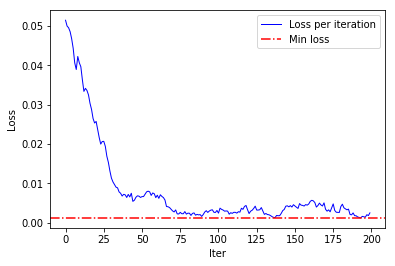

In [386]:
plt.plot(history, color='blue', linewidth=1);
plt.axhline(best_result['loss'], color='red', linestyle='-.')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.legend(['Loss per iteration', 'Min loss'])

Now we can plot again the char frequencies histogram and check if we improve the train-test split

In [387]:
train_indices = best_result['train']
test_indices = best_result['test']

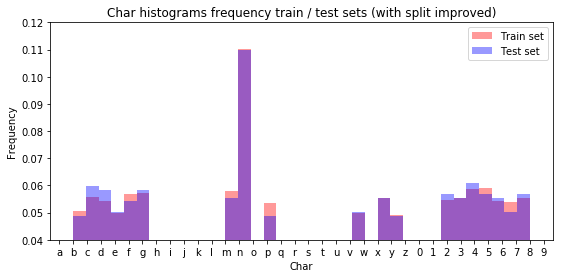

In [388]:
plt.figure(figsize=(9, 4))
plt.hist(y_labels[train_indices,:].flatten(), bins=36, color='red', alpha=0.4, density=True);
plt.hist(y_labels[test_indices,:].flatten(), bins=36, color='blue', alpha=0.4, density=True);

plt.title('Char histograms frequency train / test sets (with split improved)')
plt.xlabel('Char')
plt.ylabel('Frequency')
plt.xticks(range(0, 36))
plt.ylim((0.04, 0.12))
plt.legend(['Train set', 'Test set'])
plt.gca().set_xticklabels(alphabet);